# Instalacion de librerias

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.compose import ColumnTransformer
import joblib

# Carga y exploracion del conjunto de datos

In [92]:
df = pd.read_excel('C:/Users/salaz/OneDrive/Datos adjuntos/Proyecto MINERIA/REPORTE_RECORD_ESTUDIANTIL_ANONIMIZADO.xlsx')

# Analsis exploratorio EDA

## Dimension del dataset

In [93]:
print('Dimensiones del dataset:', df.shape)
print('\nTipos de datos:')
print(df.dtypes)

Dimensiones del dataset: (4448, 14)

Tipos de datos:
PERIODO            object
FACULTAD           object
CARRERA            object
ESTUDIANTE         object
COD_MATERIA         int64
MATERIA            object
COD_GRUPO         float64
GRUPO/PARALELO     object
ESTADO             object
PROMEDIO           object
ASISTENCIA          int64
NO. VEZ             int64
NIVEL               int64
Unnamed: 13        object
dtype: object


## Estadisticos Descriptivos

In [94]:
print('\nEstadisticas descriptivas (numericas):')
print(df.describe())


Estadisticas descriptivas (numericas):
         COD_MATERIA     COD_GRUPO   ASISTENCIA      NO. VEZ        NIVEL
count    4448.000000  4.177000e+03  4448.000000  4448.000000  4448.000000
mean   318134.131969  3.180123e+06    82.223921     1.053507     1.707284
std       124.564327  1.279258e+02    33.960853     0.246981     0.898852
min    318010.000000  3.180001e+06     0.000000     0.000000     1.000000
25%    318040.000000  3.180001e+06    89.000000     1.000000     1.000000
50%    318090.000000  3.180011e+06   100.000000     1.000000     1.000000
75%    318199.000000  3.180261e+06   100.000000     1.000000     2.000000
max    318490.000000  3.180267e+06   100.000000     3.000000     4.000000


## Normalizar nombres de columnas

In [95]:
df.columns = df.columns.str.strip().str.upper().str.replace(' ', '_')


# Reemplazo de comas por puntos y conversión a numérico
for col in ['PROMEDIO', 'ASISTENCIA']:
    if col in df.columns:
        df[col] = (
        df[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
)
df = df[df["ESTADO"].isin(["APROBADA", "REPROBADA"])]
df = df.loc[:, ~df.columns.str.contains("^UNNAMED", case=False)]
df[col] = pd.to_numeric(df[col], errors='coerce')

## Distribucion de variables numericas

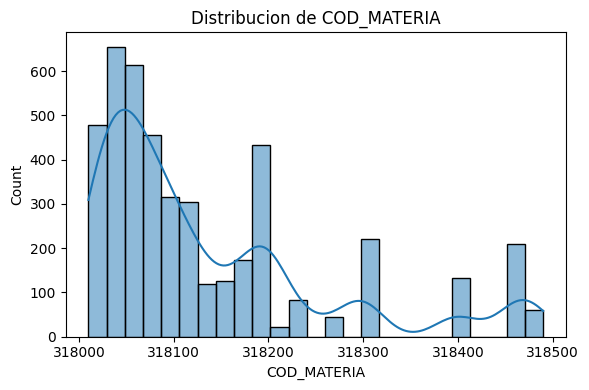

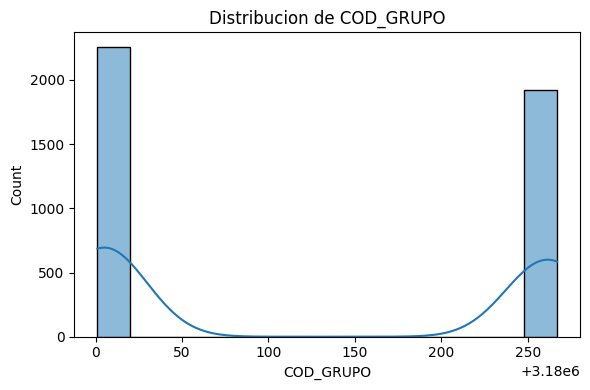

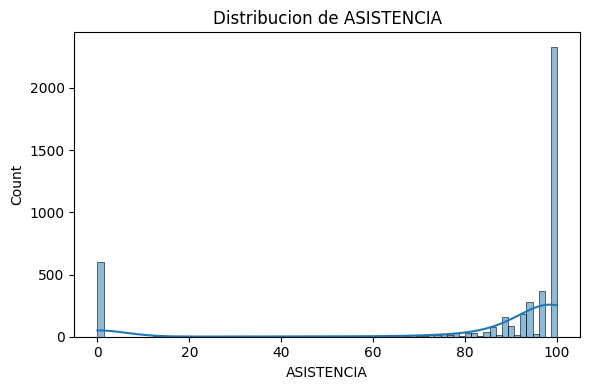

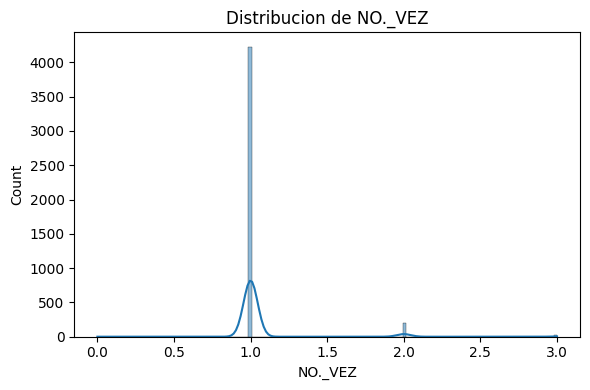

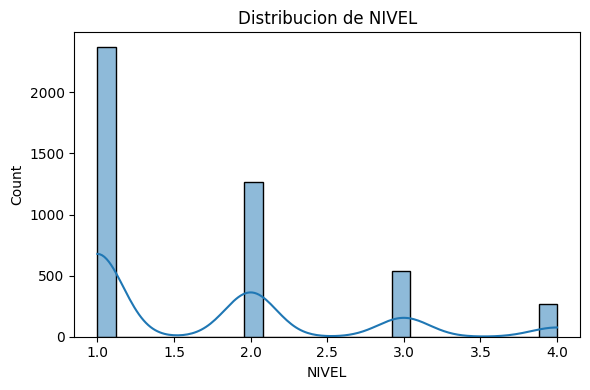

In [96]:
num_cols = df.select_dtypes(include=[np.number]).columns


for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribucion de {col}')
    plt.tight_layout()
    plt.show()

In [97]:
# convertir a texto y limpiar espacios raros
df['ESTADO'] = df['ESTADO'].astype(str)
df['ESTADO'] = df['ESTADO'].str.strip()
df['ESTADO'] = df['ESTADO'].str.upper()

# eliminar valores inválidos
df = df[df['ESTADO'].isin(['APROBADA', 'REPROBADA'])]

## Distribucion del estado Academico

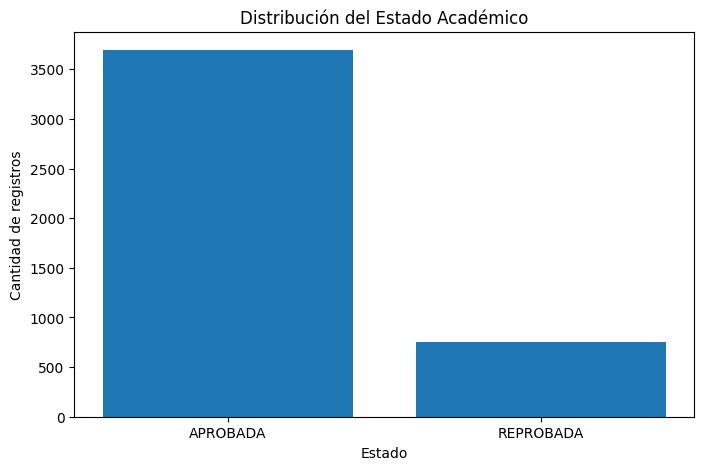

In [98]:
df2 = df.copy()
conteo_estado = df['ESTADO'].value_counts()

plt.figure(figsize=(8,5))
plt.bar(conteo_estado.index, conteo_estado.values)
plt.title('Distribución del Estado Académico')
plt.xlabel('Estado')
plt.ylabel('Cantidad de registros')
plt.show()


In [99]:
print(df2.columns)

Index(['PERIODO', 'FACULTAD', 'CARRERA', 'ESTUDIANTE', 'COD_MATERIA',
       'MATERIA', 'COD_GRUPO', 'GRUPO/PARALELO', 'ESTADO', 'PROMEDIO',
       'ASISTENCIA', 'NO._VEZ', 'NIVEL'],
      dtype='object')


## Matriz de correlacion

<Axes: >

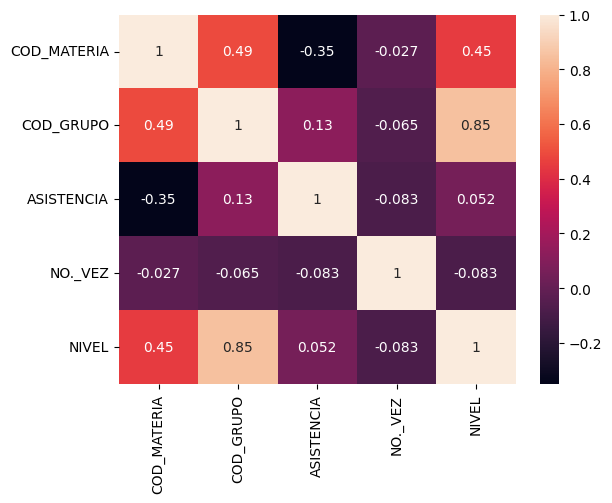

In [100]:
matriz_correlacion  = df2.corr(method ='pearson' , numeric_only=True)
sns.heatmap(data = matriz_correlacion , annot = True)

## Analisis de la variable objetivo (ESTADO)

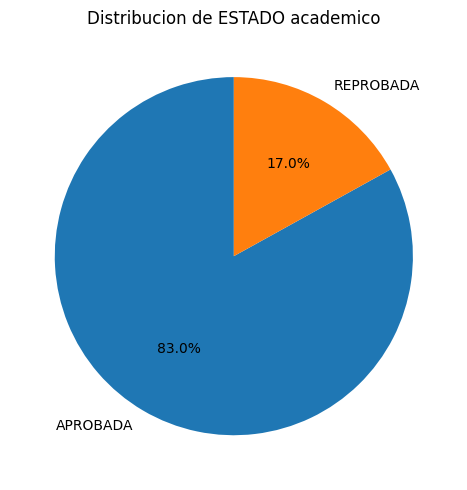

In [101]:
if 'ESTADO' in df.columns:
    estado_counts = df['ESTADO'].value_counts()


plt.figure(figsize=(5,5))
plt.pie(estado_counts, labels=estado_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribucion de ESTADO academico')
plt.tight_layout()
plt.show()

## Analisis bivariado

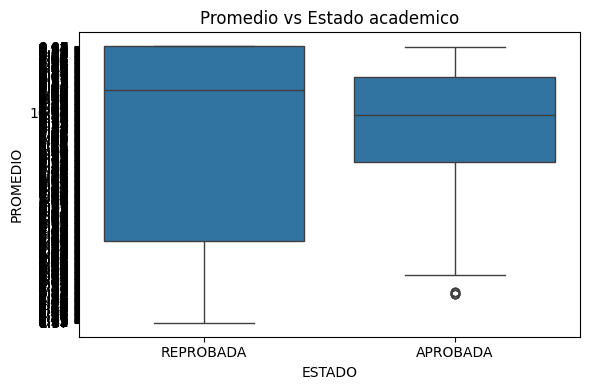

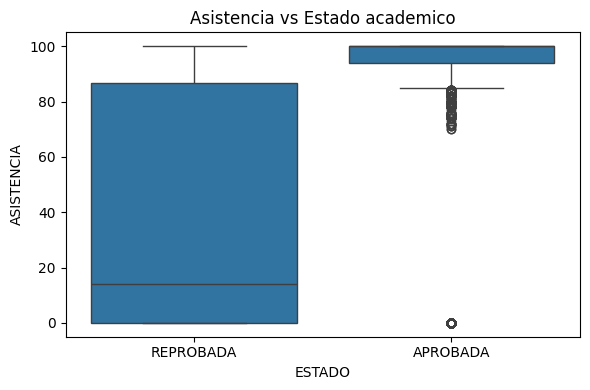

In [102]:
if 'PROMEDIO' in df.columns and 'ESTADO' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='ESTADO', y='PROMEDIO', data=df)
    plt.title('Promedio vs Estado academico')
    plt.tight_layout()
    plt.show()


if 'ASISTENCIA' in df.columns and 'ESTADO' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='ESTADO', y='ASISTENCIA', data=df)
    plt.title('Asistencia vs Estado academico')
    plt.tight_layout()
    plt.show()

# Conversion a numericos a las variables Promedio y asistencia
se necesita cambiar el formato de coma a punto y luego a numeric para que poder sacar el mean

In [103]:
df["PROMEDIO"] = (
    df["PROMEDIO"]
    .astype(str)
    .str.replace(",", ".", regex=False)
)

df["ASISTENCIA"] = (
    df["ASISTENCIA"]
    .astype(str)
    .str.replace(",", ".", regex=False)
)

# Luego convertirlo a numeric y verficar

In [104]:
df["PROMEDIO"] = pd.to_numeric(df["PROMEDIO"], errors="coerce")
df["ASISTENCIA"] = pd.to_numeric(df["ASISTENCIA"], errors="coerce")
df[["PROMEDIO", "ASISTENCIA"]].dtypes

PROMEDIO      float64
ASISTENCIA      int64
dtype: object

Luego vamos a consolidar la informacion academica de cada estudiante por periodo evitando duplicidades por asignatura y generando variables representativas en el desempeño general del estudiante y es necesaria para modelar adecuadamente la desercion

In [105]:
df_estudiante_periodo = (
    df.groupby(["ESTUDIANTE", "PERIODO"])
      .agg({
          "PROMEDIO": "mean",
          "ASISTENCIA": "mean",
          "NIVEL": "max",
          "FACULTAD": "first",
          "CARRERA": "first"
      })
      .reset_index()
)

 # Creamos la variable desercion sobre el dataset

In [106]:
df_estudiante_periodo = df_estudiante_periodo.sort_values(
    ["ESTUDIANTE", "PERIODO"]
)

df_estudiante_periodo["periodo_siguiente"] = (
    df_estudiante_periodo.groupby("ESTUDIANTE")["PERIODO"].shift(-1)
)

df_estudiante_periodo["desercion"] = (
    df_estudiante_periodo["periodo_siguiente"].isna().astype(int)
)

# Validamos la informacion sobre la Desercion y el analisis seria:
Aunque la mayoría de los registros académicos por asignatura corresponden a materias aprobadas, al analizar la continuidad académica a nivel estudiante - período se observa que un porcentaje significativo de estudiantes no continúa sus estudios, lo que indica que la deserción no depende exclusivamente del rendimiento académico.

In [107]:
df_estudiante_periodo["desercion"].value_counts()

desercion
0    575
1    488
Name: count, dtype: int64

Revisamos a los desertores


In [108]:
df_estudiante_periodo[df_estudiante_periodo["desercion"] == 1].head()

,ESTUDIANTE,PERIODO,PROMEDIO,ASISTENCIA,NIVEL,FACULTAD,CARRERA,periodo_siguiente,desercion
0,Estudiante 1,2024 - 2025 CII,0.00,0.000000,1,CIENCIAS MATEMATICAS Y FISICAS,CIENCIA DE DATOS E INTELIGENCIA ARTIFICIAL,NaN,1
4,Estudiante 10,2025 - 2026 ING1B,9.00,0.000000,2,CIENCIAS MATEMATICAS Y FISICAS,CIENCIA DE DATOS E INTELIGENCIA ARTIFICIAL,NaN,1
8,Estudiante 100,2025 - 2026 CI,8.26,80.857143,4,CIENCIAS MATEMATICAS Y FISICAS,CIENCIA DE DATOS E INTELIGENCIA ARTIFICIAL,NaN,1
9,Estudiante 101,2024 - 2025 CII,0.00,0.000000,1,CIENCIAS MATEMATICAS Y FISICAS,CIENCIA DE DATOS E INTELIGENCIA ARTIFICIAL,NaN,1
10,Estudiante 102,2024 - 2025 CII,7.43,90.000000,1,CIENCIAS MATEMATICAS Y FISICAS,CIENCIA DE DATOS E INTELIGENCIA ARTIFICIAL,NaN,1


# Definimos la variable objetivo (target) y los features (x)


In [109]:
y = df_estudiante_periodo["desercion"]
X = df_estudiante_periodo[
    ['PROMEDIO', 'ASISTENCIA', 'NIVEL', 'FACULTAD', 'CARRERA']
]

# Realizamos el preprocesamiento de los datos
con el fin de transformar las variables en un formato adecuado para el entrenamiento del modelo, escalando las variables numericas para evitar los sesgos por diferencia de magnitud y codificando las variables categoricas para permitir su correcta interpretacion por los algoritmos de aprendizaje supervisado

In [110]:
num_cols = ["PROMEDIO", "ASISTENCIA", "NIVEL"]
cat_cols = ["FACULTAD", "CARRERA"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

# Separa los datos para el entrenamiento y prueba
El conjunto de datos se dividio para entrenamiento y prueba utilizando una particion de 80/20 manteniendo la proporcion original de la variable objetivo mediante estratificacion para poder evaluar la capacidad de generalizacion del modelo

In [111]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [112]:
print(df.isna().sum().sort_values(ascending=False).head(10))

COD_GRUPO         271
FACULTAD            0
CARRERA             0
ESTUDIANTE          0
PERIODO             0
COD_MATERIA         0
MATERIA             0
GRUPO/PARALELO      0
ESTADO              0
PROMEDIO            0
dtype: int64


In [113]:
for col in df.columns:
    print(col)

PERIODO
FACULTAD
CARRERA
ESTUDIANTE
COD_MATERIA
MATERIA
COD_GRUPO
GRUPO/PARALELO
ESTADO
PROMEDIO
ASISTENCIA
NO._VEZ
NIVEL


In [114]:
df = df.loc[:, ~df.columns.str.contains("^UNNAMED", case=False)]

# Entrenamiento del modelo
Se entrena el modelo de Regresion Logistica utilizando Pipeline que integra el preprocesamiento y el clasificador, con el fin de aprender la relacion entre las variables academicas y probabilidad de desercion estudiantil


In [115]:

param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear"],
}

log_reg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

grid = GridSearchCV(
    log_reg,
    param_grid,
    scoring="recall",
    cv=5
)

grid.fit(X_train, y_train)

c:\Users\salaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\salaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
c:\Users\salaz\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty=

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step..._iter=1000))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__C': [0.01, 0.1, ...], 'classifier__penalty': ['l1', 'l2'], 'classifier__solver': ['liblinear']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candida

# Evaluacion del modelo
Para el desempeño del modelo se evaluo utilizando una matriz de confusion y metricas de clasificacion. Se priorizo el recall de la clase desercion, dado que el objetivo es poder identificar oportunamente a los estudiantes en riesgo de abandono o desercion

In [116]:
best_model = grid.best_estimator_

y_proba = best_model.predict_proba(X_test)[:, 1]


# Cambiar umbral (prueba 0.4 o 0.35)
threshold = 0.4
y_pred_threshold = (y_proba >= threshold).astype(int)

print(confusion_matrix(y_test, y_pred_threshold))
print(classification_report(y_test, y_pred_threshold))

[[40 75]
 [17 81]]
              precision    recall  f1-score   support

           0       0.70      0.35      0.47       115
           1       0.52      0.83      0.64        98

    accuracy                           0.57       213
   macro avg       0.61      0.59      0.55       213
weighted avg       0.62      0.57      0.54       213



# Presicion del modelo 

In [117]:
accuracy = accuracy_score(y_test, y_pred_threshold)
print("Accuracy:", accuracy)

Accuracy: 0.568075117370892


# Matriz de confusion

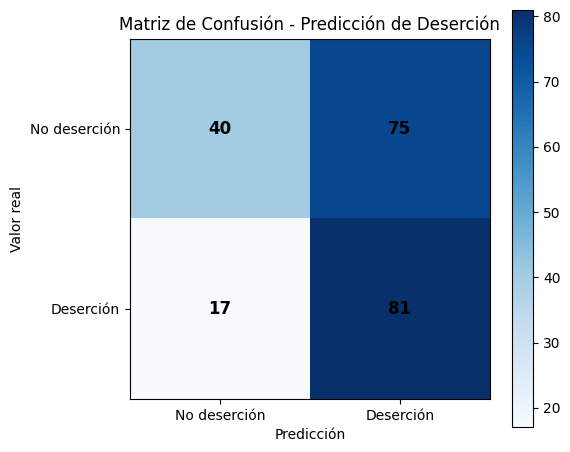

In [118]:
cm = confusion_matrix(y_test, y_pred_threshold)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")

ax.set_xlabel("Predicción")
ax.set_ylabel("Valor real")
ax.set_title("Matriz de Confusión - Predicción de Deserción")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["No deserción", "Deserción"])
ax.set_yticklabels(["No deserción", "Deserción"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                fontsize=12, fontweight="bold")

plt.colorbar(im)
plt.tight_layout()
plt.show()


# Guardamos el modelo entrenado para usarlo con la interfaz Streamlit

In [119]:
joblib.dump(best_model, 'modelRegresionLogistic.pkl')

['modelRegresionLogistic.pkl']